In [90]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from ISLP import confusion_table
from matplotlib.pyplot import subplots

from sklearn.metrics import RocCurveDisplay
roc_curve_est = RocCurveDisplay.from_estimator 
roc_curve_pred = RocCurveDisplay.from_predictions 

In [91]:
#import data
Pitching = pd.read_csv('../projectData/Pitching.csv')
People = pd.read_csv('../projectData/People.csv')
HOF = pd.read_csv('../projectData/HallOfFame.csv')

In [92]:
#IP
Pitching["IP"] = Pitching["IPouts"] / 3

In [93]:
#group all of the hall of famers that were players
HOF_inducted = HOF[(HOF['inducted'] == 'Y') & (HOF['category'] == 'Player')]
#group the hall of fame pitchers pitching based on RF feature importance list
HOF_pitching = HOF_inducted.merge(Pitching[['playerID', 'SO', 'W', 'IP', 'H', 'ER', 'HR', 'G', 'L', 'GS', 'BB']], on='playerID', how='left')

#aggregate pitching statistics per Hall of Fame player
hof_player_stats = HOF_pitching.groupby('playerID').agg({
    'SO': 'sum',
    'W': 'sum', 
    'IP': 'sum',
    'H': 'sum',
    'ER': 'sum',
    'HR': 'sum',
    'G': 'sum',
    'L': 'sum',
    'GS': 'sum',
    'BB': 'sum'
}).reset_index()

#creating the target variable
hof_player_stats['is_hof'] = 1

hof_player_stats

,playerID,SO,W,IP,H,ER,HR,G,L,GS,BB,is_hof
0,aaronha01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,alexape01,2198.0,373.0,5190.0,4868.0,1476.0,164.0,696.0,208.0,599.0,951.0,1
2,allendi01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,alomaro01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,ansonca01,1.0,0.0,4.0,4.0,2.0,2.0,3.0,1.0,0.0,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
285,wynnea01,2334.0,300.0,4564.0,4291.0,1796.0,338.0,691.0,244.0,612.0,1775.0,1
286,yastrca01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
287,youngcy01,2803.0,511.0,7356.0,7092.0,2147.0,138.0,906.0,315.0,815.0,1217.0,1
288,youngro01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [94]:
#get non hall of fame playerIDs
non_HOF = [player for player in People['playerID'] if player not in HOF_inducted['playerID']]
#group the hall of fame pitchers based on  pitching RF feature importance list
non_HOF_pitching = Pitching[~Pitching['playerID'].isin(HOF_inducted['playerID'])][['playerID', 'SO', 'W', 'IP', 'H', 'ER', 'HR', 'G', 'L', 'GS', 'BB']]

#aggregate pitching statistics per player
non_hof_player_stats = non_HOF_pitching.groupby('playerID').agg({
    'SO': 'sum',
    'W': 'sum', 
    'IP': 'sum',
    'H': 'sum',
    'ER': 'sum',
    'HR': 'sum',
    'G': 'sum',
    'L': 'sum',
    'GS': 'sum',
    'BB': 'sum'
}).reset_index()

#they aren't in the HOF so they get 0s
non_hof_player_stats['is_hof'] = 0

non_hof_player_stats

,playerID,SO,W,IP,H,ER,HR,G,L,GS,BB,is_hof
0,aardsda01,340,16,337.000000,296,160,41,331,18,0,183,0
1,aasedo01,641,66,1109.333333,1085,468,89,448,60,91,457,0
2,abadfe01,292,9,354.666667,343,149,45,406,29,6,126,0
3,abbeybe01,161,22,568.000000,686,285,18,79,40,65,192,0
4,abbeych01,0,0,2.000000,6,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10631,zulueyo01,20,0,16.333333,15,9,2,12,0,0,7,0
10632,zumayjo01,210,13,209.666667,169,71,18,171,12,0,114,0
10633,zuniggu01,16,0,19.666667,18,11,5,17,0,0,8,0
10634,zuverge01,223,32,642.333333,660,253,56,265,36,31,203,0


In [95]:
#combine Hall of Fame and non-Hall of Fame data
all_player_stats = pd.concat([hof_player_stats, non_hof_player_stats], ignore_index=True)

#remove players with IP < 1 (to avoid division by zero)
all_player_stats = all_player_stats[all_player_stats['IP'] >= 1]

In [96]:
#ERA
all_player_stats["ERA_career"] = 9 * all_player_stats["ER"] / all_player_stats["IP"]

#WHIP
all_player_stats["WHIP"] = (all_player_stats["BB"] + all_player_stats["H"]) / all_player_stats["IP"]

#BB/9, HR/9
all_player_stats["BB9"]  = 9 * all_player_stats["BB"] / all_player_stats["IP"]
all_player_stats["HR9"]  = 9 * all_player_stats["HR"] / all_player_stats["IP"]

In [97]:
#features
features = ["SO", "W", "IP", "ERA_career", "WHIP", "H", "HR9", "G", "L", "GS", "BB9", "BB"]
X = all_player_stats[features]
y = all_player_stats['is_hof']

#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=42,
                                                    stratify=y)

#scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [98]:
#first we'll try using only the nearest neighbor (k=1)
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train_scaled, y_train)

knn1_test = knn1.predict(X_test_scaled)

#confusion matrix
confusion_table(knn1_test, y_test)

Truth,0,1
Predicted,,
0,2616,18
1,9,9


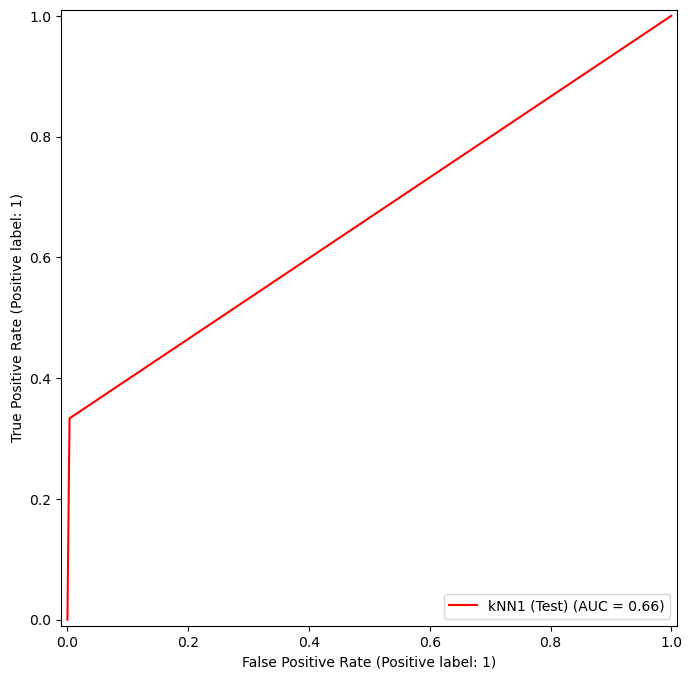

In [99]:
#creating an ROC plot and adding curves from new models to it
fig, ax = subplots(figsize=(8,8))
roc_curve_est(knn1,
              X_test_scaled,
              y_test,
              name='kNN1 (Test)',
              color='r',
              ax=ax);

In [100]:
#model using 3 nearest neighbors (k=3)
knn3 = KNeighborsClassifier(n_neighbors=3, weights='distance')
knn3.fit(X_train_scaled, y_train)

knn3_test = knn3.predict(X_test_scaled)

#confusion matrix
confusion_table(knn3_test, y_test)

Truth,0,1
Predicted,,
0,2620,16
1,5,11


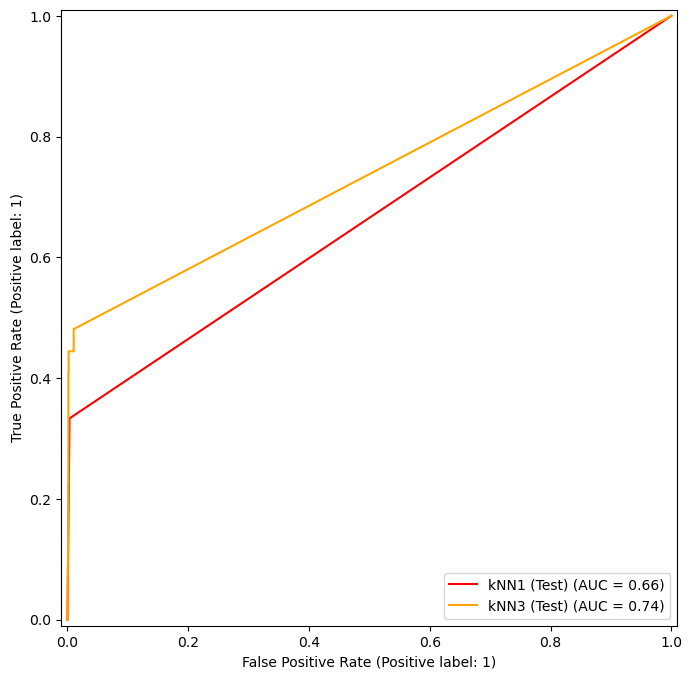

In [101]:
#adding k=3 model to the ROC curve
roc_curve_est(knn3,
              X_test_scaled,
              y_test,
              name='kNN3 (Test)',
              color='orange',
              ax=ax);

fig

In [102]:
#model using 5 nearest neighbors (k=5)
knn5 = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn5.fit(X_train_scaled, y_train)

knn5_test = knn5.predict(X_test_scaled)

#confusion matrix
confusion_table(knn5_test, y_test)

Truth,0,1
Predicted,,
0,2621,18
1,4,9


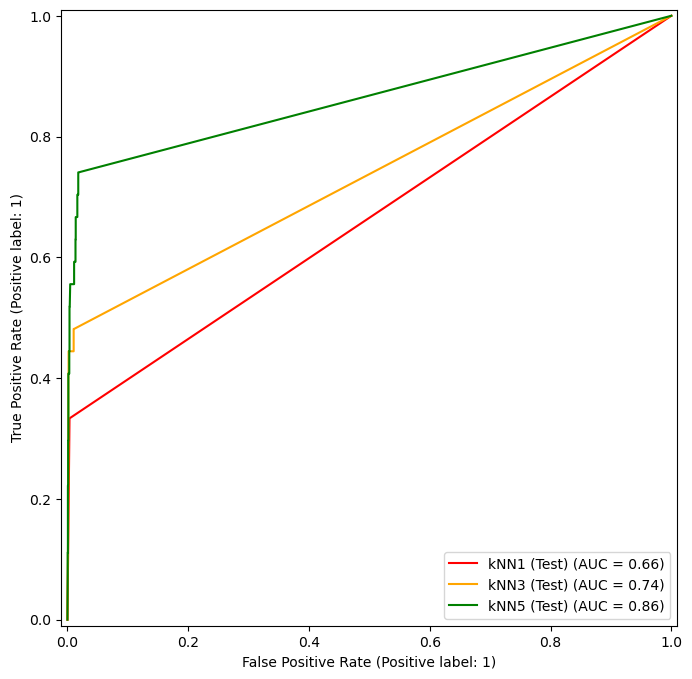

In [103]:
#adding k=5 model to the ROC curve
roc_curve_est(knn5,
              X_test_scaled,
              y_test,
              name='kNN5 (Test)',
              color='g',
              ax=ax);

fig

In [104]:
#model using 7 nearest neighbors (k=7)
knn7 = KNeighborsClassifier(n_neighbors=7, weights='distance')
knn7.fit(X_train_scaled, y_train)

knn7_test = knn7.predict(X_test_scaled)

#confusion matrix
confusion_table(knn7_test, y_test)

Truth,0,1
Predicted,,
0,2622,18
1,3,9


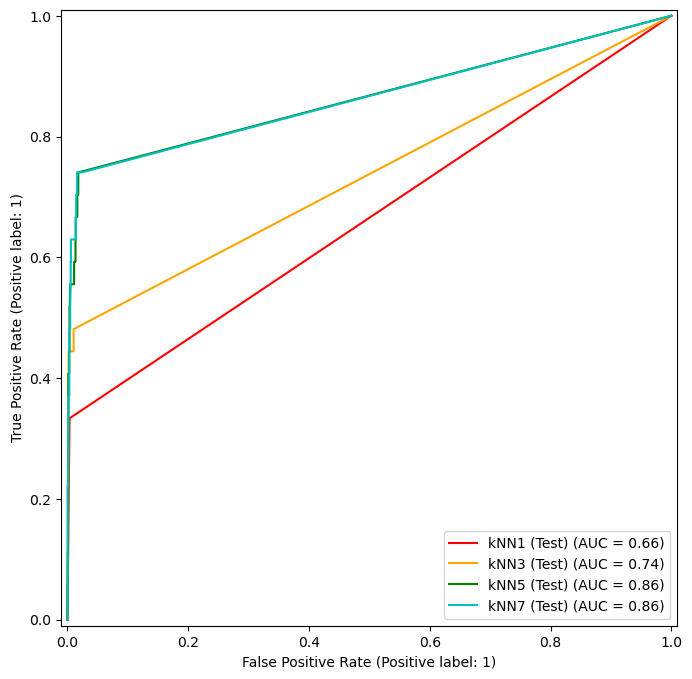

In [105]:
#adding k=7 model to the ROC curve
roc_curve_est(knn7,
              X_test_scaled,
              y_test,
              name='kNN7 (Test)',
              color='c',
              ax=ax);

fig

In [106]:
#model using 10 nearest neighbors (k=10)
knn10 = KNeighborsClassifier(n_neighbors=10, weights='distance')
knn10.fit(X_train_scaled, y_train)

knn10_test = knn10.predict(X_test_scaled)

#confusion matrix
confusion_table(knn10_test, y_test)

Truth,0,1
Predicted,,
0,2622,18
1,3,9


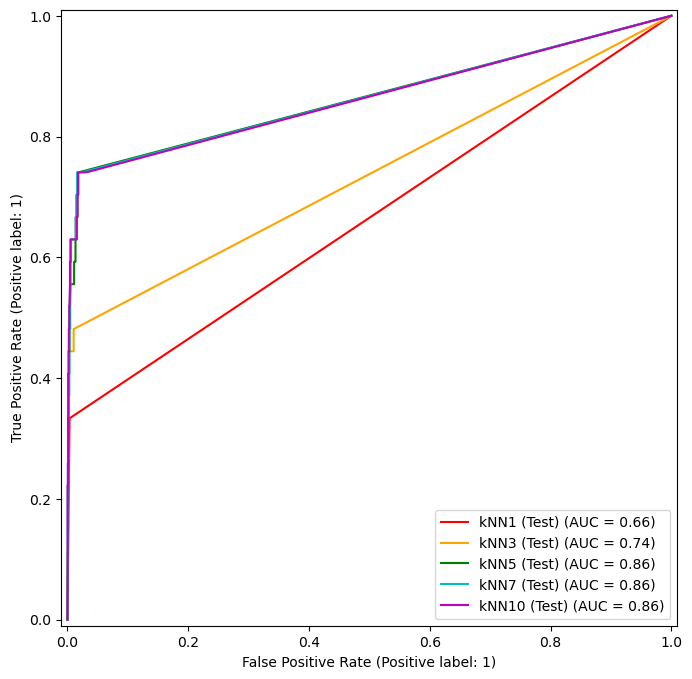

In [107]:
#adding k=10 model to the ROC curve
roc_curve_est(knn10,
              X_test_scaled,
              y_test,
              name='kNN10 (Test)',
              color='m',
              ax=ax);

fig

In [108]:
#model using 50 nearest neighbors (k=50)
knn50 = KNeighborsClassifier(n_neighbors=50, weights='distance')
knn50.fit(X_train_scaled, y_train)

knn15_test = knn50.predict(X_test_scaled)

#confusion matrix
confusion_table(knn15_test, y_test)

Truth,0,1
Predicted,,
0,2624,21
1,1,6


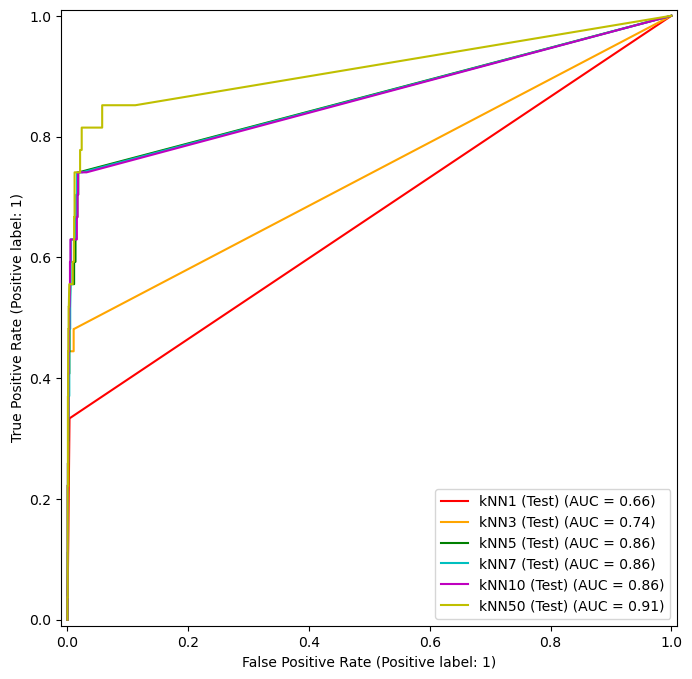

In [109]:
#adding k=50 model to the ROC curve
roc_curve_est(knn50,
              X_test_scaled,
              y_test,
              name='kNN50 (Test)',
              color='y',
              ax=ax);

fig

In [110]:
#model using 100 nearest neighbors (k=100)
knn100 = KNeighborsClassifier(n_neighbors=100, weights='distance')
knn100.fit(X_train_scaled, y_train)

knn100_test = knn100.predict(X_test_scaled)

#confusion matrix
confusion_table(knn100_test, y_test)

Truth,0,1
Predicted,,
0,2624,25
1,1,2


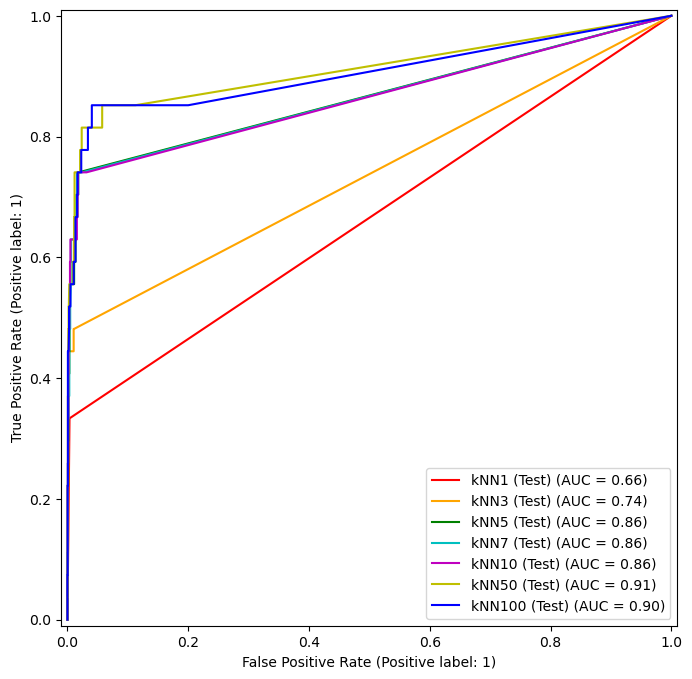

In [111]:
#adding k=100 model to the ROC curve
roc_curve_est(knn100,
              X_test_scaled,
              y_test,
              name='kNN100 (Test)',
              color='b',
              ax=ax);

fig

In [112]:
#function to predict HOF probability for specific players using knn50
def predict_hof_probability(player_names):
    
    #get player IDs from names
    player_ids = []
    for name in player_names:
        player_match = People[(People['nameFirst'] + ' ' + People['nameLast'] == name)]
        if len(player_match) > 0:
            player_ids.append(player_match.iloc[0]['playerID'])
        else:
            print(f"Player '{name}' not found in database")
            player_ids.append(None)
    
    #get pitching stats of the players
    player_pitching = Pitching[Pitching['playerID'].isin([pid for pid in player_ids if pid is not None])]
    
    #aggregate stats per player
    player_stats = player_pitching.groupby('playerID').agg({
        'SO': 'sum',
        'W': 'sum', 
        'IP': 'sum',
        'H': 'sum',
        'ER': 'sum',
        'HR': 'sum',
        'G': 'sum',
        'L': 'sum',
        'GS': 'sum',
        'BB': 'sum'
    }).reset_index()

    #ERA
    player_stats["ERA_career"] = 9 * player_stats["ER"] / player_stats["IP"]

    #WHIP
    player_stats["WHIP"] = (player_stats["BB"] + player_stats["H"]) / player_stats["IP"]

    #BB/9, HR/9
    player_stats["BB9"]  = 9 * player_stats["BB"] / player_stats["IP"]
    player_stats["HR9"]  = 9 * player_stats["HR"] / player_stats["IP"]
    
    player_stats = player_stats.merge(People[['playerID', 'nameFirst', 'nameLast']], on='playerID', how='left')
    player_stats['FullName'] = player_stats['nameFirst'] + ' ' + player_stats['nameLast']
    
    #use rate-based features for prediction
    X_players = player_stats[features]
    
    #scale features
    X_players_scaled = scaler.transform(X_players)
    
    #make predictions using knn50 model
    probabilities = knn50.predict_proba(X_players_scaled)[:, 1]
    predictions = knn50.predict(X_players_scaled)
    
    #create results dataframe
    results = pd.DataFrame({
        'Player': player_stats['FullName'],
        'HOF_Probability': probabilities,
        'Predicted_HOF': predictions
    })
    
    return results.sort_values('HOF_Probability', ascending=False)

In [113]:
# Test with known Hall of Famers
known_hof_players = [
    "Mike Mussina",
    "Nolan Ryan", 
    "Roy Halladay",
    "Bob Gibson",
    "Walter Johnson"
]

print("\nKnown Hall of Famers - knn50 Model (Rate Statistics Only):")
print("=" * 60)
hof_validation = predict_hof_probability(known_hof_players)
for idx, row in hof_validation.iterrows():
    status = "✓ HOF" if row['Predicted_HOF'] == 1 else "✗ Not HOF"
    print(f"{row['Player']:20} | {row['HOF_Probability']:.1%} | {status}")

# Test with active players
active_players = [
    "Tarik Skubal",         #top 3 are good pichers
    "Paul Skenes", 
    "Garrett Crochet",
    "Angel Chivilli",       #bottom two are not good pitchers
    "Antonio Senzatela"
]

print("\nActive Players - knn50 Model (Rate Statistics Only):")
print("=" * 60)
active_predictions = predict_hof_probability(active_players)
for idx, row in active_predictions.iterrows():
    status = "✓ Future HOF" if row['Predicted_HOF'] == 1 else "✗ Unlikely HOF"
    print(f"{row['Player']:20} | {row['HOF_Probability']:.1%} | {status}")


Known Hall of Famers - knn50 Model (Rate Statistics Only):
Bob Gibson           | 100.0% | ✓ HOF
Roy Halladay         | 100.0% | ✓ HOF
Walter Johnson       | 100.0% | ✓ HOF
Nolan Ryan           | 100.0% | ✓ HOF
Mike Mussina         | 32.7% | ✗ Not HOF

Active Players - knn50 Model (Rate Statistics Only):
Angel Chivilli       | 0.0% | ✗ Unlikely HOF
Garrett Crochet      | 0.0% | ✗ Unlikely HOF
Antonio Senzatela    | 0.0% | ✗ Unlikely HOF
Paul Skenes          | 0.0% | ✗ Unlikely HOF
Tarik Skubal         | 0.0% | ✗ Unlikely HOF
